# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = []
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8183 - accuracy: 0.7268

947/947 [==============================] - 3678s 4s/step - loss: 0.8183 - accuracy: 0.7268 - val_loss: 0.8043 - val_accuracy: 0.7399
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.7574

947/947 [==============================] - 3341s 4s/step - loss: 0.7110 - accuracy: 0.7574 - val_loss: 0.7494 - val_accuracy: 0.7449
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.7692

947/947 [==============================] - 3362s 4s/step - loss: 0.6645 - accuracy: 0.7692 - val_loss: 0.7159 - val_accuracy: 0.7505
Epoch 4/200
947/947 [==============================] - 3047s 3s/step - loss: 0.6330 - accuracy: 0.7824 - val_loss: 0.7350 - val_accuracy: 0.7480
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6059 - accuracy: 0.7888

947/947 [==============================] - 3385s 4s/step - loss: 0.6059 - accuracy: 0.7888 - val_loss: 0.6870 - val_accuracy: 0.7580
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.7974

947/947 [==============================] - 3312s 3s/step - loss: 0.5809 - accuracy: 0.7974 - val_loss: 0.6580 - val_accuracy: 0.7740
Epoch 7/200
947/947 [==============================] - 3073s 3s/step - loss: 0.5536 - accuracy: 0.8032 - val_loss: 0.7787 - val_accuracy: 0.7485
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.8082

947/947 [==============================] - 3300s 3s/step - loss: 0.5366 - accuracy: 0.8082 - val_loss: 0.6520 - val_accuracy: 0.7842
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.8165

947/947 [==============================] - 3294s 3s/step - loss: 0.5188 - accuracy: 0.8165 - val_loss: 0.5356 - val_accuracy: 0.8099
Epoch 10/200
947/947 [==============================] - 3019s 3s/step - loss: 0.5363 - accuracy: 0.8121 - val_loss: 0.6870 - val_accuracy: 0.7579
Epoch 11/200
947/947 [==============================] - 3037s 3s/step - loss: 0.5347 - accuracy: 0.8136 - val_loss: 0.5374 - val_accuracy: 0.8159
Epoch 12/200
947/947 [==============================] - 3023s 3s/step - loss: 0.4855 - accuracy: 0.8277 - val_loss: 0.5615 - val_accuracy: 0.8131
Epoch 13/200
947/947 [==============================] - 3142s 3s/step - loss: 0.4692 - accuracy: 0.8327 - val_loss: 0.6983 - val_accuracy: 0.8033
Epoch 14/200
947/947 [==============================] - 3081s 3s/step - loss: 0.4658 - accuracy: 0.8336 - val_loss: 0.8226 - val_accuracy: 0.7900
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.8391

947/947 [==============================] - 3519s 4s/step - loss: 0.4478 - accuracy: 0.8391 - val_loss: 0.4829 - val_accuracy: 0.8312
Epoch 16/200
947/947 [==============================] - 3094s 3s/step - loss: 0.4598 - accuracy: 0.8379 - val_loss: 0.5036 - val_accuracy: 0.8198
Epoch 17/200
947/947 [==============================] - 3063s 3s/step - loss: 0.4251 - accuracy: 0.8468 - val_loss: 0.4994 - val_accuracy: 0.8299
Epoch 18/200
947/947 [==============================] - 3087s 3s/step - loss: 0.4863 - accuracy: 0.8292 - val_loss: 0.7353 - val_accuracy: 0.7579
Epoch 19/200
947/947 [==============================] - 3046s 3s/step - loss: 0.4867 - accuracy: 0.8274 - val_loss: 0.4835 - val_accuracy: 0.8297
Epoch 20/200
947/947 [==============================] - 3145s 3s/step - loss: 0.3973 - accuracy: 0.8566 - val_loss: 0.5119 - val_accuracy: 0.8280
Epoch 21/200
947/947 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8602

947/947 [==============================] - 3286s 3s/step - loss: 0.3837 - accuracy: 0.8602 - val_loss: 0.4636 - val_accuracy: 0.8386
Epoch 22/200
947/947 [==============================] - 3180s 3s/step - loss: 0.3808 - accuracy: 0.8631 - val_loss: 0.5318 - val_accuracy: 0.8147
Epoch 23/200
947/947 [==============================] - 3264s 3s/step - loss: 0.3687 - accuracy: 0.8638 - val_loss: 0.4926 - val_accuracy: 0.8349
Epoch 24/200
947/947 [==============================] - 3377s 4s/step - loss: 0.3504 - accuracy: 0.8743 - val_loss: 0.4967 - val_accuracy: 0.8357
Epoch 25/200
947/947 [==============================] - 3053s 3s/step - loss: 0.3392 - accuracy: 0.8761 - val_loss: 0.4908 - val_accuracy: 0.8400
Epoch 26/200
947/947 [==============================] - 3033s 3s/step - loss: 0.3319 - accuracy: 0.8786 - val_loss: 0.4851 - val_accuracy: 0.8361
Epoch 27/200
947/947 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8840

947/947 [==============================] - 3499s 4s/step - loss: 0.3142 - accuracy: 0.8840 - val_loss: 0.4461 - val_accuracy: 0.8441
Epoch 28/200
947/947 [==============================] - 3116s 3s/step - loss: 0.3100 - accuracy: 0.8867 - val_loss: 1.9912 - val_accuracy: 0.5923
Epoch 29/200
947/947 [==============================] - 3201s 3s/step - loss: 0.3109 - accuracy: 0.8862 - val_loss: 0.4660 - val_accuracy: 0.8382
Epoch 30/200
947/947 [==============================] - 3163s 3s/step - loss: 0.2815 - accuracy: 0.8959 - val_loss: 0.5306 - val_accuracy: 0.8134
Epoch 31/200
947/947 [==============================] - 3069s 3s/step - loss: 0.2754 - accuracy: 0.9001 - val_loss: 0.5024 - val_accuracy: 0.8283
Epoch 32/200
947/947 [==============================] - 3174s 3s/step - loss: 0.2642 - accuracy: 0.9037 - val_loss: 0.6096 - val_accuracy: 0.8061
Epoch 33/200
947/947 [==============================] - 3056s 3s/step - loss: 0.2598 - accuracy: 0.9039 - val_loss: 0.5798 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 313s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9708227335389339,
 'basal cell carcinoma': 0.9873826278648403,
 'dermatofibroma': 0.9453371592539455,
 'melanoma': 0.9466788606902095,
 'nevus': 0.970203183886267,
 'pigmented benign keratosis': 0.9796921332635617,
 'seborrheic keratosis': 0.9592460519612837,
 'solar lentigo': 0.9584302448513554,
 'squamous cell carcinoma': 0.973335905467529,
 'vascular lesion': 0.999916407929305}

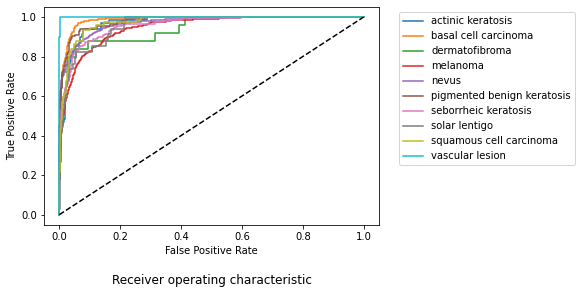

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

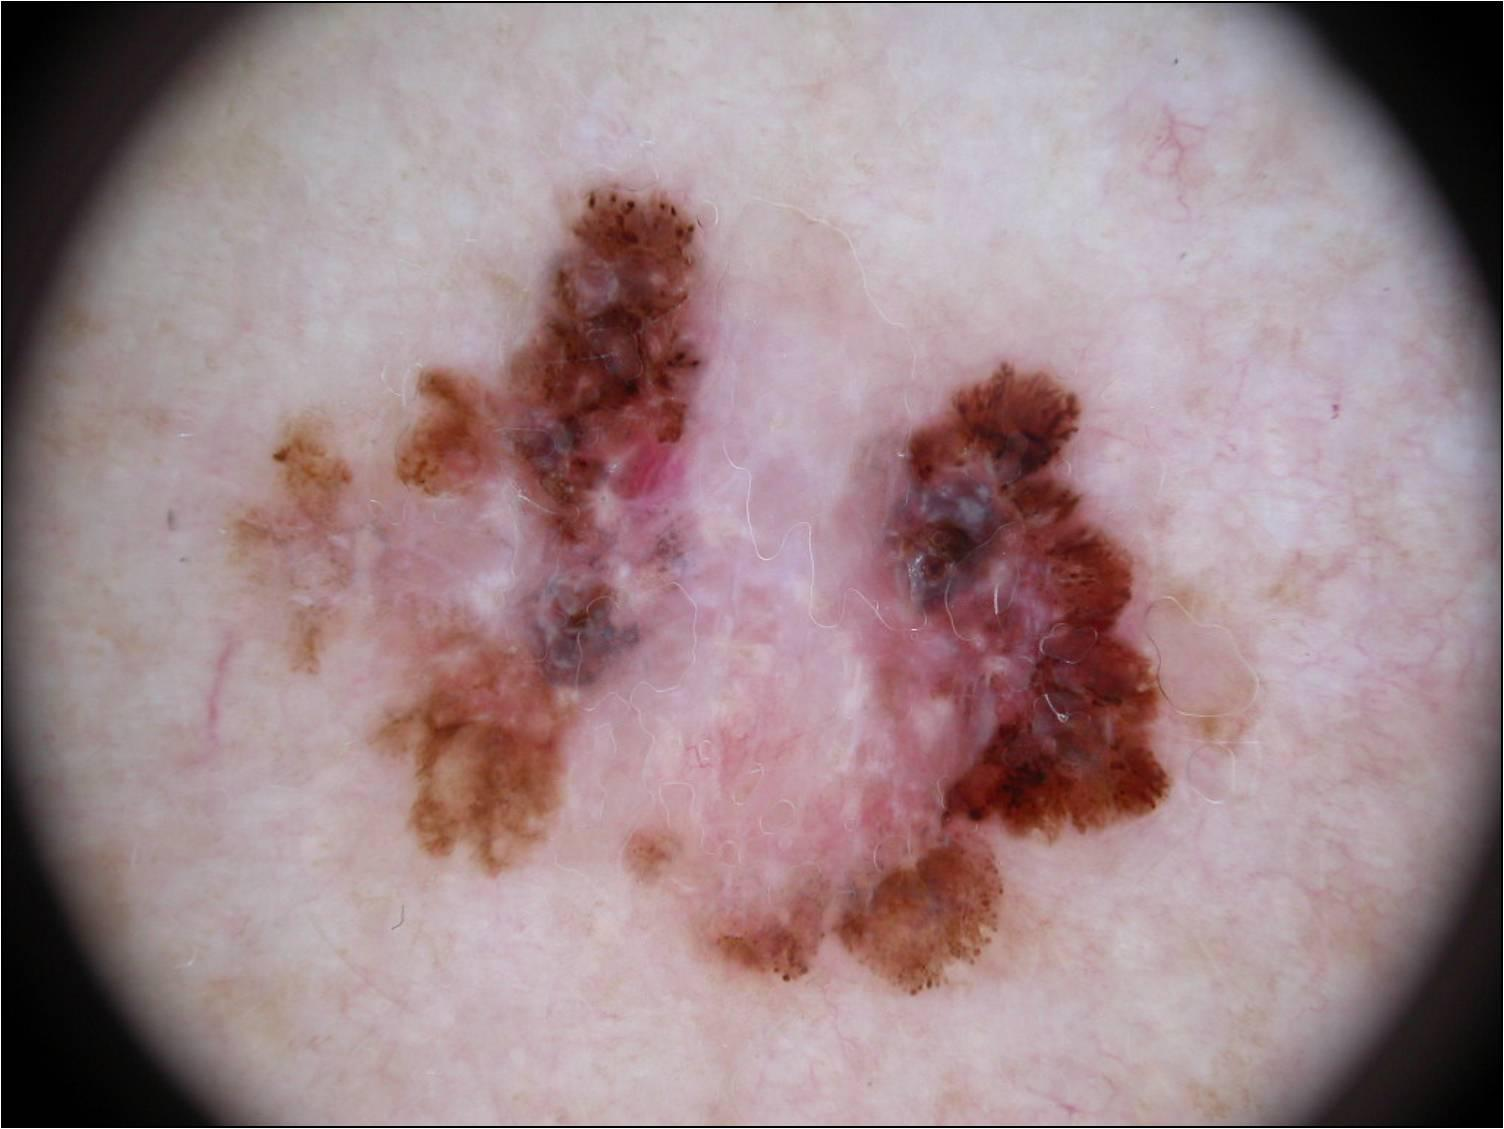

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'conv_7b')

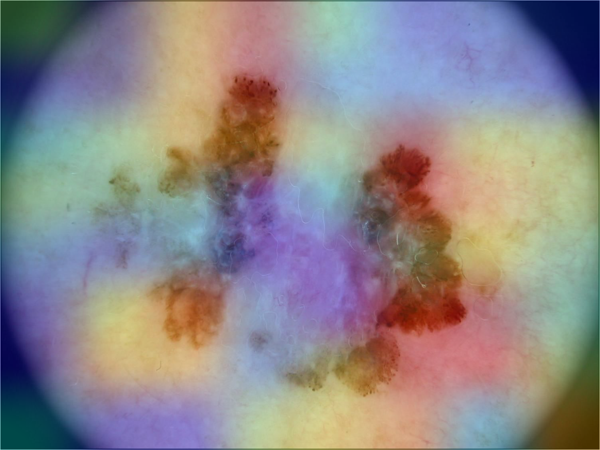

In [23]:
display_gradcam(melanoma_im_path, heatmap)